# Bollinger Bands Strategy and Backtesting

Prepared by Samalie Piwan   
Email : spiwan@andrew.cmu.edu

## 1. Strategy Implementation

In [3]:
# Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from io import StringIO
#Import the backtesting library
from backtesting import Backtest, Strategy
import backtesting
from tabulate import tabulate

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Define the function bb_backtest_strategy() that implements and plots the Bollinger Bands

In [14]:
def bb_backtest_strategy(symbol, data, date_col, pricing_col, param_window, param_std):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        param_window:
            The number of days to use when computing the Simple Moving Average
        param_length:
            The short period, also used when calculating the SMA
        param_std:
            The long period
            
    Return
    -----------
        None
    
    """

    main_df_indexed = data
    
    #Generate the bollinger bands
    #length (int): The short period. Default: 5
    #std (int): The long period. Default: 2
    #Function returns lower, mid, upper, bandwidth, and percent columns
    
    main_df_indexed.ta.bbands(close = pricing_col, length = sma_window, std= param_std, append = True)

    #Create f strings for the column names
    str_upper_band = f"BBU_{sma_window}_{std}.0"
    str_middle_band = f"BBM_{sma_window}_{std}.0"
    str_lower_band = f"BBL_{sma_window}_{std}.0"

    # Generate the trading signals
    # 1 Represents a buy
    # -1 represents a sell
    # 0 represents a hold
    bands_signal = []
    signal = 0

    for i in range(len(main_df_indexed[pricing_col])):
        # Today's price is below the lower band
        # The price has dropped below the bands and a rise is expected
        # We want to buy

        if main_df_indexed[pricing_col][i] < main_df_indexed[str_lower_band][i]:
            # If we are not already in a buy position
            # Add today's price to the buy list
            # Update the signal to show we are in buy
            signal = 1
            bands_signal.append(signal)

        # Today's price is above the upper band
        # The price has increased above the bands and a drop is expected
        # We want to sell
        elif main_df_indexed[pricing_col][i] > main_df_indexed[str_upper_band][i]:

            # If we are not already in a sell position
            # Add today's price to the sell list
            # Update the signal to show we are in sell
            signal = -1
            bands_signal.append(signal)
        else:
            signal = 0
            bands_signal.append(signal)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(main_df_indexed[pricing_col])):
        # If we are in a buy position, set our position as buy
        if bands_signal[i] == 1:
            position[i] = 1
        # If we are in a sell position, set our position as sell
        elif bands_signal[i] == -1:
            position[i] = 0
        # Otherwise use yesterday's position
        else:
            position[i] = position[i-1]
            
    plt_df = main_df_indexed.copy().dropna()
            
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Closing Price | SMA "+str(param_window))
    plt_df[pricing_col].plot(label = 'Prices', color = 'skyblue')
    plt_df[str_upper_band].plot(label = 'Upper Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    plt_df[str_middle_band].plot(label = 'Middle Band '+str(param_window), linestyle = '--', linewidth = 1.2, color = 'grey')
    plt_df[str_lower_band].plot(label = 'Lower Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    plt.fill_between(plt_df.index, plt_df[str_lower_band],plt_df[str_upper_band], color='grey', alpha = 0.05)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper right')
    plt.show()

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Signal'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Position'] = position
    
    # Calculate Returns and Cummulative Returns and append to the DataFrame
    
    #New column name is LOGRET_1
    main_df_new.ta.log_return(close=pricing_col, append=True)
    
    #New column name is CUMLOGRET_1
    main_df_new.ta.log_return(close=pricing_col,cumulative=True, append=True)
    
    #Calculate the performance on the strategy data
    main_df_new['Strategy'] = main_df_new['Position'] * main_df_new['LOGRET_1']
    main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum()
    
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Equity Lines | SMA "+str(param_window))
    plt.plot(main_df_new['CUMLOGRET_1'], label = "Returns")
    plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    sns.set_style("whitegrid")
    plt.legend(loc='upper left')
    plt.show()

Declare the Simple Moving Average Window  and Standard Deviation to run the first version of the strategy with

In [15]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
sma_window = 20
std = 2

Set the fiat currency pair to run the first version of the strategy on

In [16]:
from_symbol = "EUR"
to_symbol = "JPY"
interval = "60min"
api_key = "CV4O3KUIMS9TVCLR"

### 1.1 Strategy and Returns on Intraday FX data

Load the intraday 1 Hour Data from the **Alpahvantage** API

In [17]:
# Load the data from the API
url = f"https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol={from_symbol}&to_symbol={to_symbol}&interval={interval}&apikey={api_key}&datatype=csv"
request = requests.get(url)

#Convert the CSV to a pandas dataframe
data = StringIO(request.text)
csv_res_df = pd.read_csv(data)

# Convert to DataFrame
data_df = csv_res_df.copy()
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
pricing_df = data_df.set_index('timestamp')
pricing_df.sort_index(ascending=True, inplace=True)

Run the **bb_backtest_strategy()** function on the Intraday FX data to plot the Bollinger Bands, and the performance of the strategy against the returns

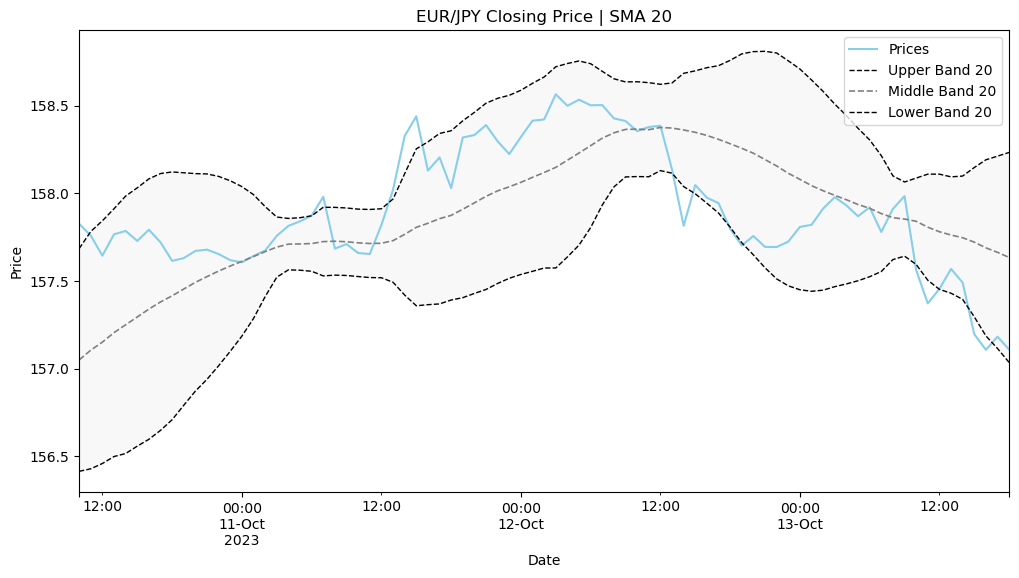

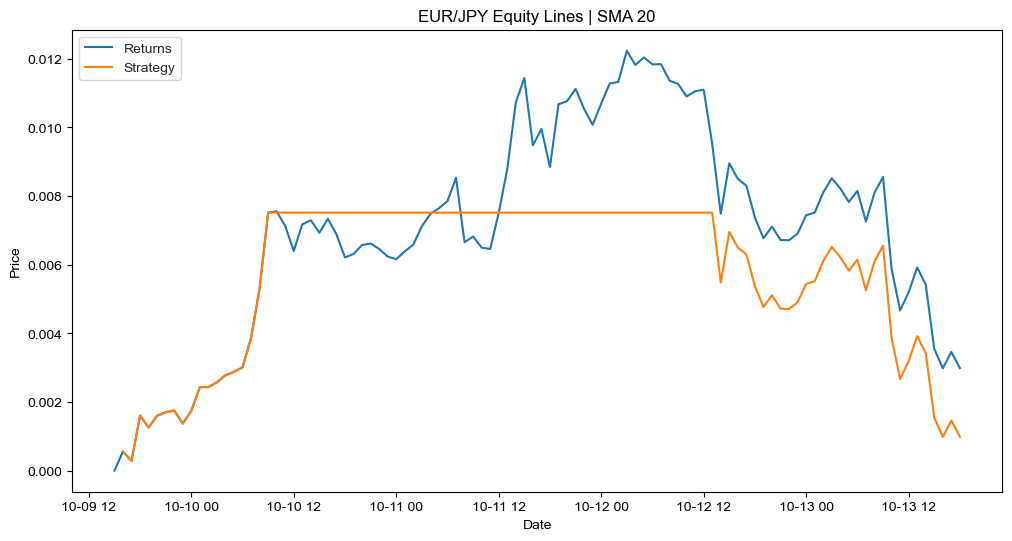

In [18]:
bb_backtest_strategy(f"{from_symbol}/{to_symbol}", pricing_df, 'timestamp', 'close', param_window = sma_window, param_std = std)

### 1.2 Strategy and Returns on Annual FX data  - Jan 2005 to Dec 2013

Load the 19-year monthly data from the **Alpahvantage** API

In [19]:
# Load the monthly data from the API
monthly_url = f"https://www.alphavantage.co/query?function=FX_MONTHLY&from_symbol={from_symbol}&to_symbol={to_symbol}&apikey={api_key}&datatype=csv"
monthly_request = requests.get(monthly_url)

#Convert the CSV to a pandas dataframe
monthly_data = StringIO(monthly_request.text)
csv_res_monthly_df = pd.read_csv(monthly_data)

# Convert to DataFrame
monthly_data_df = csv_res_monthly_df.copy()
monthly_data_df['timestamp'] = pd.to_datetime(monthly_data_df['timestamp'])
monthly_pricing_df = monthly_data_df.set_index('timestamp')
monthly_pricing_df.sort_index(ascending=True, inplace=True)

Seperate the 19 year monthly data into two sets:
1. **'backtest_dataset'** - Contains 2005 to 2013 to use for backtesting the strategy
2. **'rerun_dataset'** - Contains 2013 to 2022 for re-testing the strategy with optimized parameters after backtesting

In [20]:
#Seperate the data into two sets:
backtest_dataset = pd.DataFrame(monthly_pricing_df.loc['2005-01-01' : '2013-12-31'].copy())
rerun_dataset = pd.DataFrame(monthly_pricing_df.loc['2014-01-01':'2022-12-31'].copy())

Run the **bb_backtest_strategy()** function on backtest_dataset to plot the Bollinger Bands, and the performance of the strategy against the returns

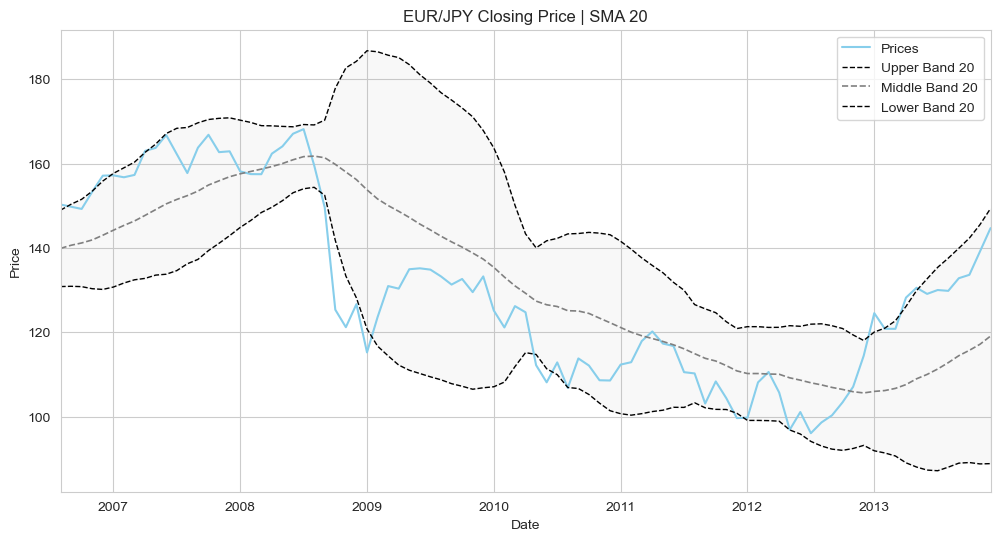

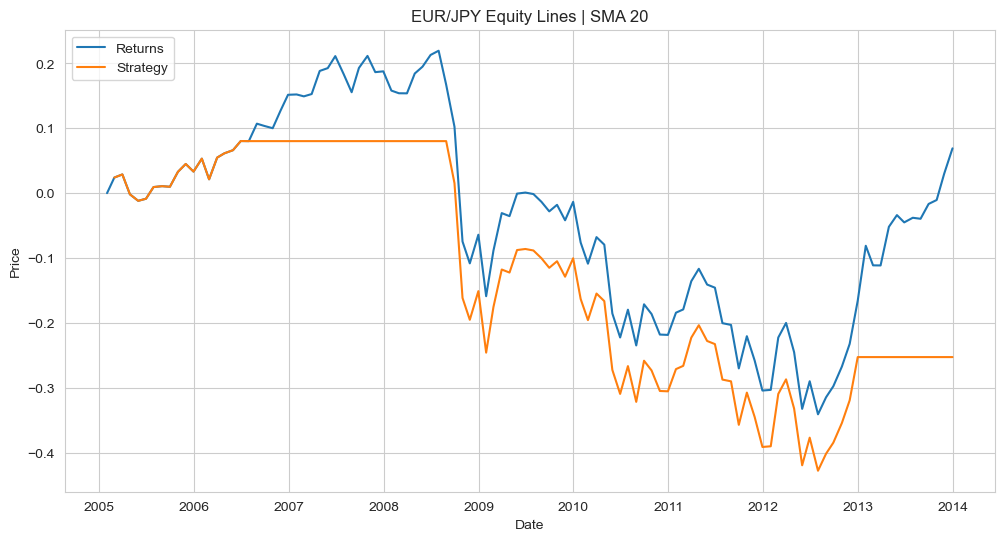

In [21]:
bb_backtest_strategy(f"{from_symbol}/{to_symbol}", backtest_dataset, 'timestamp', 'close', param_window = sma_window, param_std = std)

## 2. Backtesting

### 2.1 Backtesting Strategy Setup

For this strategy, we will focus on optimizing the hyperparameters below:
    
- Simple Moving Average (SMA) Window
- Standard Deviation

Define the Indicator(Bollinger Bands) and Buy / Sell Strategy that the backtesting.py library will optimize

In [22]:
def indicator(data, sma_window, std):
    bbands = ta.bbands(close = data.Close.s, length = sma_window, std = std)
    return bbands.to_numpy().T[:3]

class BollingerBandsStrategy(Strategy):
    
    std_cust = std
    sma_window_cust = sma_window
    
    def init(self):
        self. bbands = self.I(indicator, self.data, self.std_cust, self.sma_window_cust)

    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] > lower_band[-1]:
                self.buy()

Rename the columns to a format backtesting.py recognize 

In [23]:
backtest_dataset = backtest_dataset.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close'})

Create and an instance of our Backtest class using:
- The **'backtest_dataset'** from section 2
- Cash of $10,000
- Commission at 1%

In [31]:
bt = Backtest(backtest_dataset, BollingerBandsStrategy, cash=10000, commission=0.01)
stats = bt.run()

Create a table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the backtest

In [32]:
backtest_results_table = [["Peak Equity", stats['Equity Peak [$]']],["Final Equity",stats['Equity Final [$]']],["Sharpe Ratio", round(stats['Sharpe Ratio'], 5)], 
                          ["PnL", f"${round(stats['_trades']['PnL'][0],3)}"],
                          ["Return %", f"{round(stats['Return [%]'], 3)}%"]]
print(f"Backesting reults with investment of {10000} and commission of 1%\n")
print(tabulate(backtest_results_table, headers=["Result", "Value"]))                         

Backesting reults with investment of 10000 and commission of 1%

Result        Value
------------  ------------------
Peak Equity   11983.122299999999
Final Equity  9928.3823
Sharpe Ratio  0.0
PnL           $-71.618
Return %      -0.716%


Plot the Equity curve from the backtest

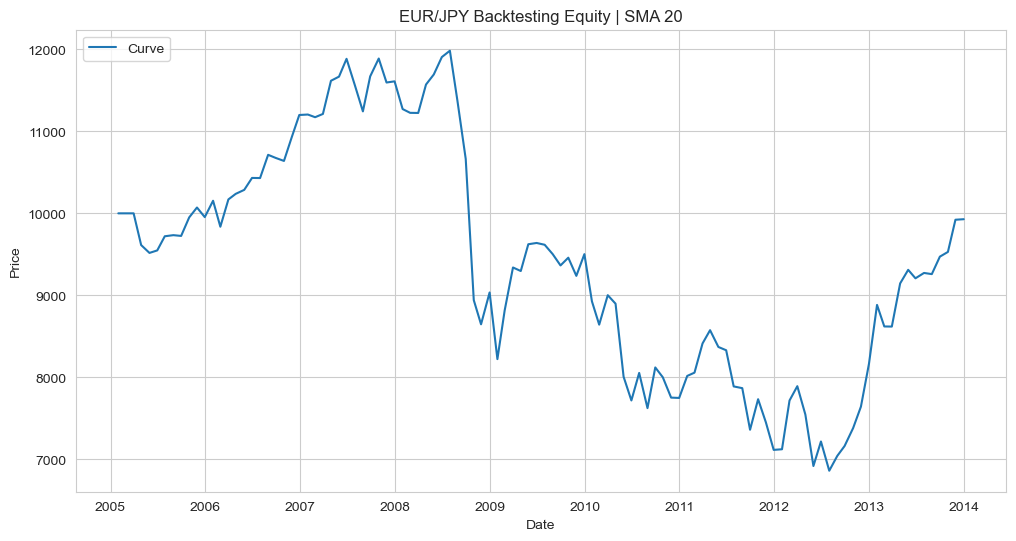

In [29]:
# Select the Equity as a new dataframe
equity = pd.DataFrame(stats['_equity_curve']['Equity']).copy()

#Plot the equity curve
plt.figure(figsize = (12,6))
plt.title(from_symbol+"/"+to_symbol+" Backtesting Equity | SMA "+str(sma_window))
plt.plot(equity, label = "Curve")
plt.xlabel("Date")
plt.ylabel("Price")
sns.set_style("whitegrid")
plt.legend(loc='upper left')
plt.show()

### 2.2 Optmizing strategy to select best-performing hyperparameters

Run the backesting.py **optimize()** function using the Simple Moving Average Window and Standard Deviation as the parameters to optmize

In [30]:
optimized_stats, heatmap = bt.optimize(
    sma_window_cust = range(20, 50, 5),
    std_cust = range(2, 10, 1),
    maximize = "Equity Final [$]",
    return_heatmap = True
)

hm = heatmap.groupby(["sma_window_cust", "std_cust"]).mean().unstack()

  0%|          | 0/12 [00:00<?, ?it/s]

Create a second table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the optimized backtest

In [34]:
optimized_backtest_results_table = [["Peak Equity", optimized_stats['Equity Peak [$]']],["Final Equity",optimized_stats['Equity Final [$]']],["Sharpe Ratio", round(optimized_stats['Sharpe Ratio'], 5)], 
                          ["PnL", f"${round(optimized_stats['_trades']['PnL'][0],3)}"],
                          ["Return %", f"{round(optimized_stats['Return [%]'], 3)}%"]]
print(f"Backesting reults with SMA Window and Standard Deviation optimized\n")
print(tabulate(optimized_backtest_results_table, headers=["Result", "Value"]))                         

Backesting reults with SMA Window and Standard Deviation optimized

Result        Value
------------  ----------
Peak Equity   12471.2596
Final Equity  10329.6996
Sharpe Ratio  0.10776
PnL           $329.7
Return %      3.297%


Plot a heatmap of the best-performing hyperparameters

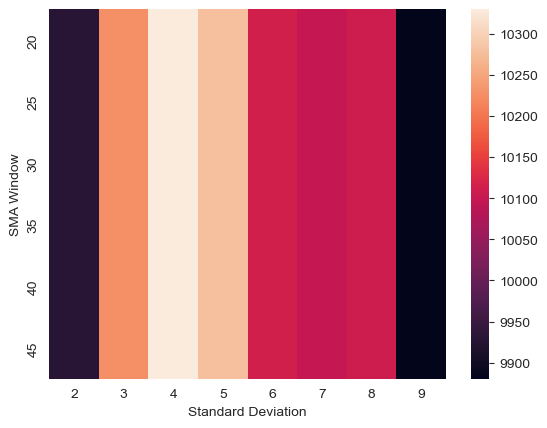

In [33]:
pricing_hm = sns.heatmap(hm)
pricing_hm.set(xlabel='Standard Deviation', ylabel='SMA Window')
plt.show()

### 2.3 Cross validation

Run an instance of our Backtest class using  from section 2 using:
- The **'rerun_dataset'** from section 2
- Cash of $10,000
- Commission at 1%